<a href="https://colab.research.google.com/github/ricfrr/deepLearning/blob/master/market_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from numpy import array
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


In [2]:

from google.colab import drive
drive.mount('/content/gdrive')
!mkdir dataset
!cp "gdrive/My Drive/dataset/nasdaq100_padding.csv" dataset/


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
from tensorboardcolab import TensorBoardColab

# Instantiate visualizer
tb = TensorBoardColab(graph_path='./log')

Using TensorFlow backend.


Wait for 8 seconds...
TensorBoard link:
https://7eb14b0e.ngrok.io


In [0]:
class Loader():

    def __init__(self, path):
        self.path = path
        self.x = []
        self.y = []
        self.y_test = []
        self.x_test = []
        self.x_train = []
        self.y_train = []
        self.test_size = 0
        self.numpoints = 0
        self.device = torch.device(
            'cuda:0' if torch.cuda.is_available() else 'cpu')
        #self.to(self.device)


    def loadData(self):
        print("start Loading data")
        data = pandas.read_csv(self.path)
        i = 0
        for index, row in data.iterrows():
            self.x.append(i)
            self.y.append(row['GOOGL'])
            i = i+1
        self.numpoints = i
        self.test_size = int(self.numpoints*0.7)
        sc = MinMaxScaler(feature_range = (0, 1))
        self.y = np.array(self.y)
        self.y = sc.fit_transform(self.y.reshape(-1, 1))
        self.x = np.array(self.x)
        self.x = self.x.reshape(-1,1)
        for k in range(30, self.numpoints-self.test_size):
          self.x_train.append(self.x[k-30:k])
          self.y_train.append(self.y[k])
        
        for i in range (self.numpoints-self.test_size,self.numpoints-self.test_size+100):
          self.x_test.append(self.x[i-30:i]) 
          self.y_test.append(self.y[i])
        
        self.reshape()
        print("finished Loading data")

    def reshape(self):
        self.x_train = np.array(self.x_train)
        self.x_test = np.array(self.x_test)
        self.y_test = np.array(self.y_test)
        self.y_train = np.array(self.y_train)
        
        self.toTensor()

    def toTensor(self):
        self.x_train = torch.from_numpy(self.x_train).type(torch.Tensor)
        self.x_test = torch.from_numpy(self.x_test).type(torch.Tensor)
        self.y_train = torch.from_numpy(self.y_train).type(torch.Tensor)
        self.y_test = torch.from_numpy(self.y_test).type(torch.Tensor)
        
        self.x_train = torch.Tensor(self.x_train).to(self.device)
        self.y_train = torch.Tensor(self.y_train).to(self.device)
        
        self.x_test = torch.Tensor(self.x_test).to(self.device)
        self.y_test = torch.Tensor(self.y_test).to(self.device)

    def plotData(self):
        plt.plot(self.x,self.y)
        plt.title('google nasdaq data')
        plt.xlabel('days')
        plt.ylabel('value')
        plt.show()

In [0]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.x_train =[]
    self.lstm = nn.LSTM(input_size=1, hidden_size=25, num_layers=6, dropout=0.2,batch_first=True)
    self.fc = nn.Linear(25, 1)
    self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')   
    self.h0 = []
    self.c0 = []
    self.to(self.device)

  def forward(self):
    #x.to(self.device)
    #batches = x.size(0)
    #self.initialize_hidden() 
    (x, _) = self.lstm(self.x_train,(self.h0, self.c0))   
    x = x[:,-1,:]  # Keep only the output of the last iteration.
    x =self.fc(x)
    return x
  def loadData(self,x):
    self.x_train = x 
    self.x_train.to(self.device)
    
  def initialize_hidden(self):
    batches = self.x_train.size(0)
    self.h0 = torch.randn([6, batches, 25]).to(self.device)
    self.c0 = torch.randn([6, batches, 25]).to(self.device)
  
  def forecast(self,x):
    x.to(self.device)
    batches = x.size(0)

    #self.h0 = torch.randn([3, batches, 48]).to(self.device)
    #self.c0 = torch.randn([3, batches, 48]).to(self.device)
    (x, _) = self.lstm(x)   
    x = x[:,-1,:]  # Keep only the output of the last iteration.
    x =self.fc(x)
    return x


start Loading data
finished Loading data
Epoch 1/1000, loss = 0.17790372669696808
Epoch 2/1000, loss = 0.1767556369304657
Epoch 3/1000, loss = 0.17562590539455414
Epoch 4/1000, loss = 0.17453345656394958
Epoch 5/1000, loss = 0.17336969077587128
Epoch 6/1000, loss = 0.17225387692451477
Epoch 7/1000, loss = 0.17115069925785065
Epoch 8/1000, loss = 0.17004863917827606
Epoch 9/1000, loss = 0.16891051828861237
Epoch 10/1000, loss = 0.16774515807628632
Epoch 11/1000, loss = 0.16671042144298553
Epoch 12/1000, loss = 0.16556328535079956
Epoch 13/1000, loss = 0.16455528140068054
Epoch 14/1000, loss = 0.16341562569141388
Epoch 15/1000, loss = 0.16233371198177338
Epoch 16/1000, loss = 0.16125020384788513
Epoch 17/1000, loss = 0.16016563773155212
Epoch 18/1000, loss = 0.1591009646654129
Epoch 19/1000, loss = 0.15800465643405914
Epoch 20/1000, loss = 0.15693247318267822
Epoch 21/1000, loss = 0.1558493971824646
Epoch 22/1000, loss = 0.15477420389652252
Epoch 23/1000, loss = 0.15380358695983887
Epoch

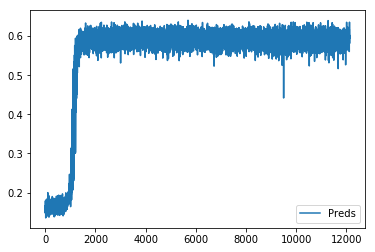

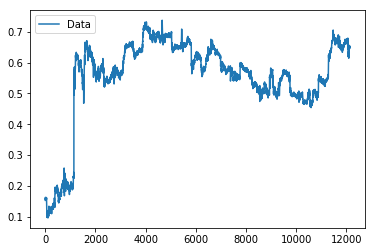

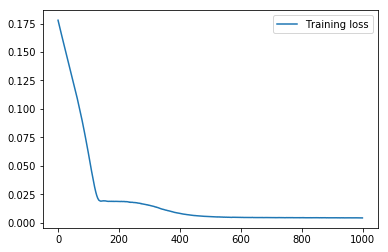

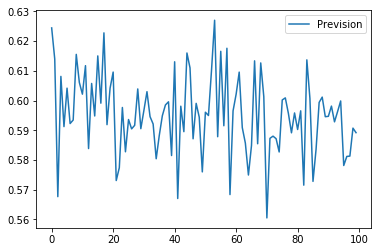

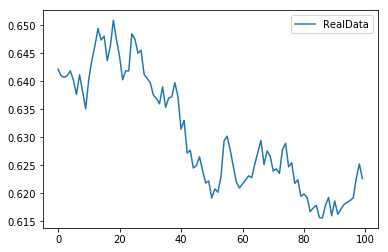

In [32]:
loader = Loader('/content/dataset/nasdaq100_padding.csv')
loader.loadData()


visualization_name ="marker_forecasting" #for plotting tensorboard
model = Model()
model.loadData(loader.x_train)
model.initialize_hidden()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),weight_decay=0.00001, lr = 0.0001)

n_epochs = 1000
trainig_loss = np.zeros(n_epochs)

for epoch in range(n_epochs):
  model.train()
  optimizer.zero_grad()
  y_ = model.forward()  
  loss = criterion(y_, loader.y_train)
  loss.backward()
  optimizer.step()
  trainig_loss[epoch] = loss.item()

  print(f"Epoch {epoch+1}/{n_epochs}, loss = {loss.item()}")
  tb.save_value('Loss/train_loss', visualization_name, epoch + 1, loss.item())
  # Update plots 
  tb.flush_line(visualization_name)
  


y_ = torch.Tensor.cpu(y_)
y_train = torch.Tensor.cpu(loader.y_train)
plt.plot(y_.detach().numpy(), label="Preds")
plt.legend()
plt.show()

plt.plot(y_train.detach().numpy(), label="Data")
plt.legend()
plt.show()

plt.plot(trainig_loss, label="Training loss")
plt.legend()
plt.show()


market_forecast = model.forecast(loader.x_test)
forec = torch.Tensor.cpu(market_forecast)
y_test  = torch.Tensor.cpu(loader.y_test)

plt.plot(forec.detach().numpy(), label="Prevision")
plt.legend()
plt.show()


plt.plot(y_test.detach().numpy(), label="RealData")
plt.legend()
plt.show()





